On a high level, we are implementing a CNN - LSTM model, where sequential images were used as input into the CNN to extract the features using keras-video-generator library, and the subsequent fully connected layer from the convolution is used as input into the LSTM using time distributed network for training. The idea is explained in more detail here - https://medium.com/smileinnovation/training-neural-network-with-image-sequence-an-example-with-video-as-input-c3407f7a0b0f

I have made some slight modifications (simplify) to the model architecture and data processing to suit this project.

# Converting sequential images to video 

In [8]:
#dependencies
import os
import cv2
from collections import OrderedDict

In [ ]:
#function used to convert sequential images to avi
def image_to_video(data_types, class_names):
    if not os.path.exists('videos'):
        os.mkdir('videos') 
    for data_type in data_types:
        if not os.path.exists("videos/" + data_type):
                os.mkdir("videos/" + data_type)
        for class_item in class_names:
            if not os.path.exists("videos/" + data_type + "/" + class_item):
                os.mkdir("videos/" + data_type + "/" + class_item)
            image_folder = "images/" + data_type + "/" + class_item
            list_of_filenames = os.listdir(image_folder)
            file_names = []
            for filename in list_of_filenames:
                file_names.append(filename[0:4])
            file_names = list(OrderedDict.fromkeys(file_names))
            for file_name in file_names:
                images = [img for img in os.listdir(image_folder) if img[0:4] == file_name]
                frame = cv2.imread(os.path.join(image_folder, images[0]))
                height, width, layers = frame.shape
                video_name = "videos/" + data_type + "/" + class_item + "/" + file_name + "_video.avi"
                video = cv2.VideoWriter(video_name, 0, 1, (width,height))
                for image in images:
                    video.write(cv2.imread(os.path.join(image_folder, image)))
                cv2.destroyAllWindows()
                video.release()
    return None

In [ ]:
data_types = ["training", "testing"]
class_names = ["flip", "notflip"]
image_to_video(data_types, class_names)

# Extracting and organizing the video files for training and validation

In [2]:
#dependencies
import zipfile as zf
import shutil
from fnmatch import fnmatch

In [3]:
shutil.rmtree('training')
shutil.rmtree('testing')

In [4]:
#functions used in this section
def file_count(folder):
        l = []
        for root, dirs, files in os.walk(folder):
            for file in files:
                if fnmatch(file, "*.avi"):
                    l.append(file)
        return len(l)

In [5]:
#extracting the images
files = zf.ZipFile("videos.zip", 'r')
files.extractall('/notebooks')
files.close()

In [9]:
#restructuring the data
dest = os.getcwd()
for folder in os.listdir('videos'):
    dir_to_move = os.path.join('videos', folder)
    shutil.move(dir_to_move, dest)
shutil.rmtree('videos')

In [10]:
print('Total number of training data: {0}'.format(file_count("training")))
print('Total number of testing data: {0}'.format(file_count("testing")))

Total number of training data: 117
Total number of testing data: 115


In [11]:
#initializing the minimum number of frame we want each training and testing video to be
NBFRAME = 5

In [12]:
#deleting any videos that does not have a minimum of 5 frames
from fnmatch import fnmatch
dsets = ['training', 'testing']
for folder in dsets:
    root = folder
    pattern = "*.avi"
    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern):
                frame_number = cv2.VideoCapture(os.path.join(path,name)).get(cv2.CAP_PROP_FRAME_COUNT)
                if frame_number < NBFRAME:
                    os.remove(os.path.join(path,name))

In [13]:
print('Total number of training data: {0}'.format(file_count("training")))
print('Total number of testing data: {0}'.format(file_count("testing")))

Total number of training data: 117
Total number of testing data: 65


The idea here is to randomly choose <em>n</em> number of frames from the videos, and use that as the input to our CNN. Here, I have arbitarily chosen 5 as the minimum frame requirement. I could have picked higher or lower number. In fact, it could potentially be a hyperparameter that can be optimized. 

In the step above, I am deleting some videos which does not meet minimum number of frames. We have deleted 40 images from the testing, which is not ideal but the library I am using would like to have all datasets to have the same number of frames. This is an issue that has been brought up in their repo (https://github.com/metal3d/keras-video-generators/issues/36). A solution could be adding padding (empty frames) to shorter videos that does not meet the minimum number of frames. For the time being, I am just going to test out this library without any modifications. 

# Keras Video Generator

In [7]:
!pip -q install git+https://github.com/metal3d/keras-video-generators.git
!pip -q install opencv-python-headless

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [14]:
#dependecies
import glob
import tensorflow
from keras_video import VideoFrameGenerator

In [15]:
#use sub directories names as classes
classes = [i.split(os.path.sep)[1] for i in glob.glob('training/*')]
classes.sort()
classes

['flip', 'notflip']

In [42]:
# some global params
SIZE = (150, 270)
CHANNELS = 3
NBFRAME = 5
BS = 8

# pattern to get videos and classes
train_glob_pattern='training/{classname}/*.avi'
valid_glob_pattern='testing/{classname}/*.avi'


# for data augmentation
data_aug = tensorflow.keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)

# Create video frame generator
train = VideoFrameGenerator(
    rescale=1 / 255.0,
    classes=classes, 
    glob_pattern=train_glob_pattern,
    nb_frames=NBFRAME,
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

valid = VideoFrameGenerator(
    rescale=1 / 255.0,
    classes=classes, 
    glob_pattern=valid_glob_pattern,
    nb_frames=NBFRAME,
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    use_frame_cache=True)

Total data: 2 classes for 117 files for train
Total data: 2 classes for 65 files for train


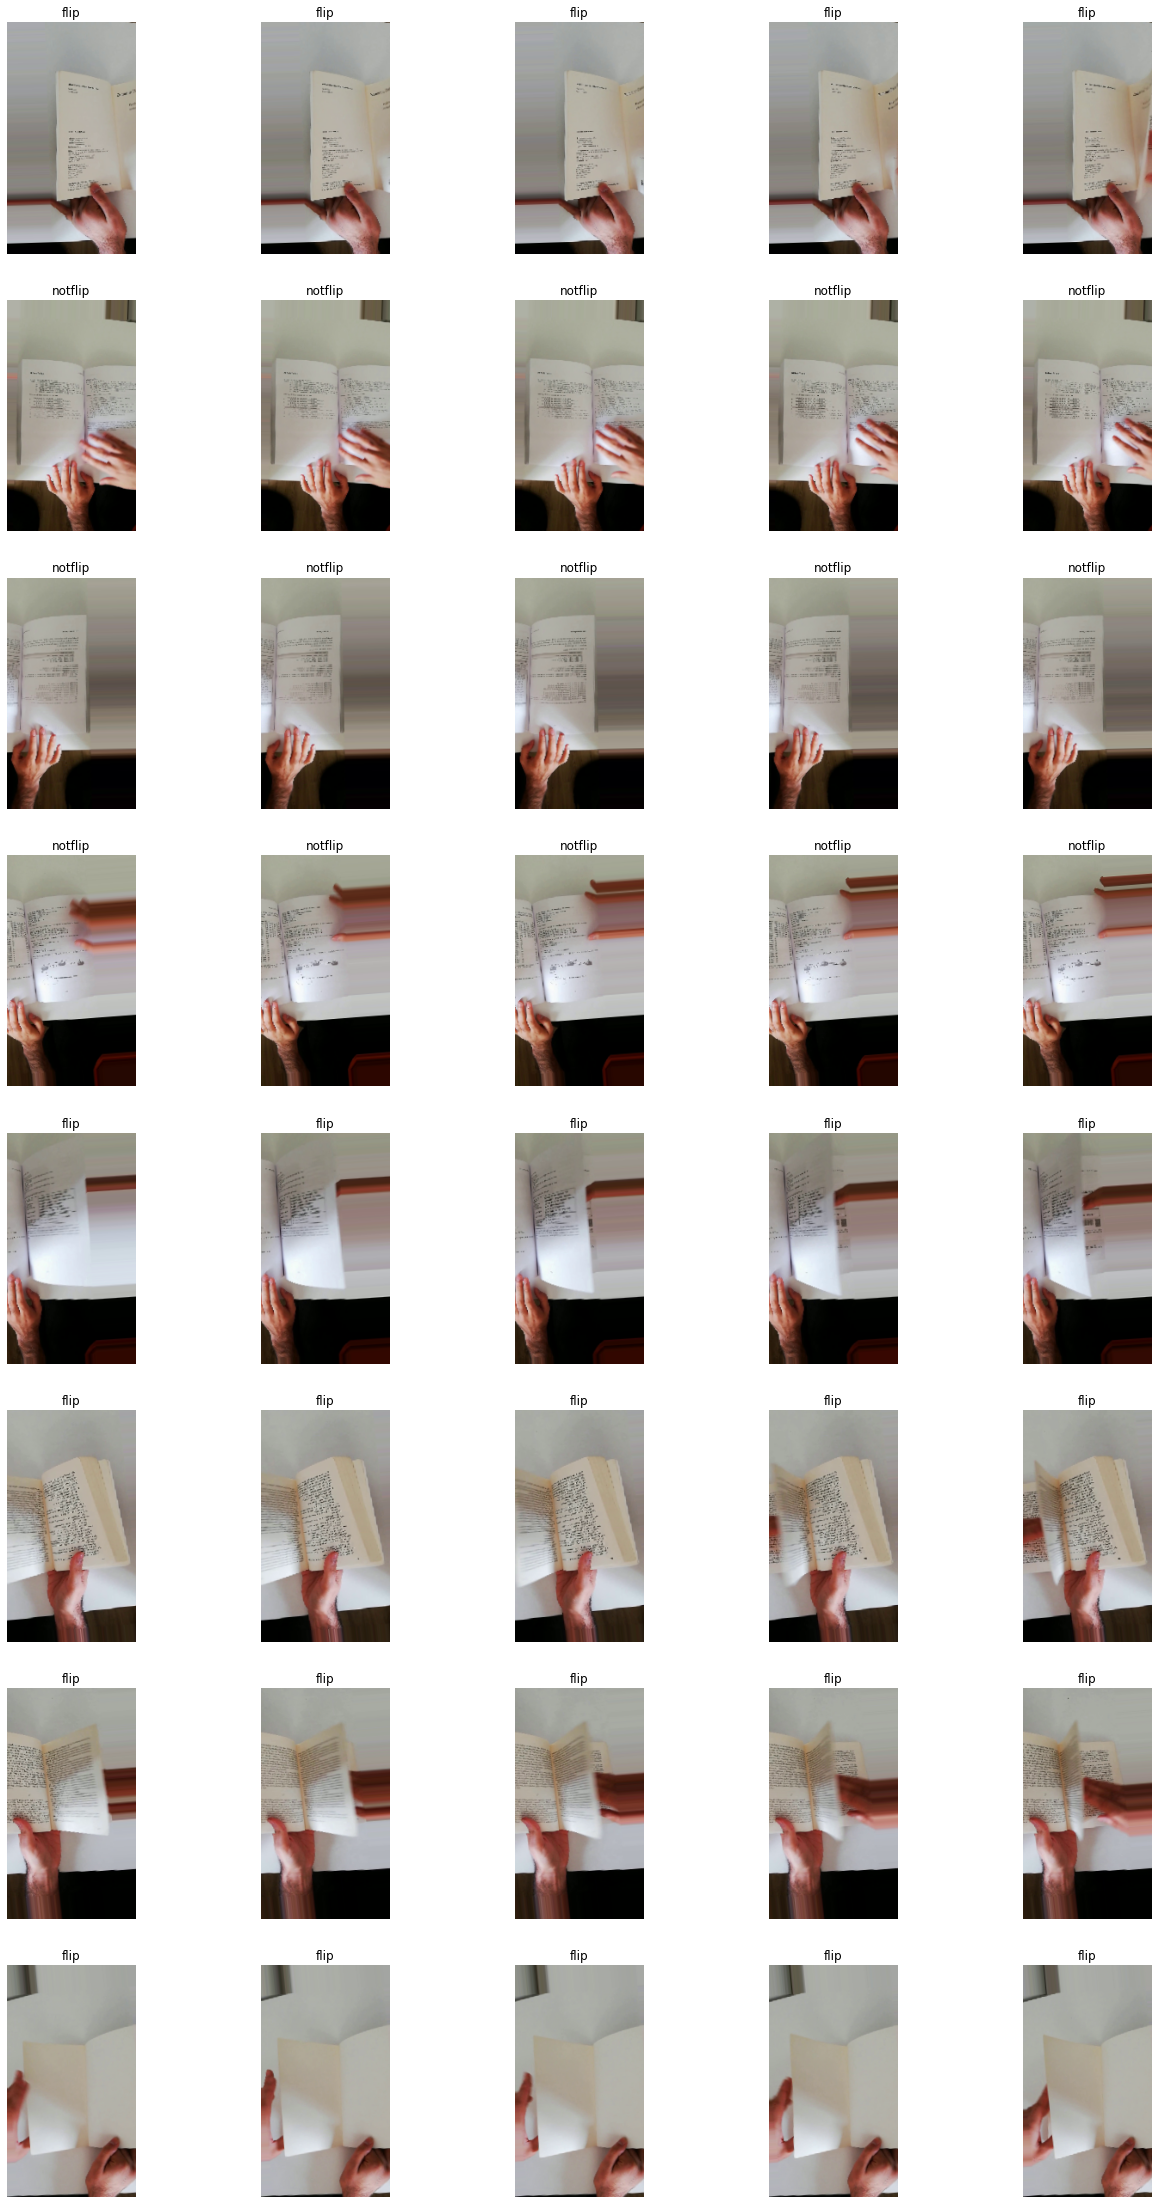

In [43]:
#sample batch
import keras_video.utils
keras_video.utils.show_sample(train)

# CNN - LSTM Architecture

In [21]:
!pip -q install tensorflow-addons

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [44]:
#dependecies
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense
import tensorflow_addons as tfa

In [55]:
#custom model created with 8 convolution layer
def build_convnet(shape=(150, 270, 3)):
    momentum = .9
    model = tensorflow.keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape, padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    return model

In [56]:
def action_model(shape=(5, 150, 270, 3)):
    # Create our convnet with (150, 270, 3) input shape
    convnet = build_convnet(shape[1:])
    # then create our final model
    model = tensorflow.keras.Sequential()
    # add the convnet with (5, 150, 270, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(LSTM(256))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    return model

In [57]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 150, 270, 3)
model = action_model(INSHAPE)
optimizer = tensorflow.keras.optimizers.Adam(1e-5)
model.compile(
    optimizer,
    'binary_crossentropy',
    metrics=['accuracy', tfa.metrics.F1Score(num_classes=2, average='macro')]
)

In [58]:
EPOCHS=75
callbacks = [tensorflow.keras.callbacks.ReduceLROnPlateau(verbose=1)]
history = model.fit(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks)

Epoch 1/75
14/14 [==============================] - 7s 400ms/step - loss: 0.7006 - accuracy: 0.4375 - f1_score: 0.3686 - val_loss: 0.6936 - val_accuracy: 0.5312 - val_f1_score: 0.3469
Epoch 2/75
14/14 [==============================] - 5s 316ms/step - loss: 0.6766 - accuracy: 0.6250 - f1_score: 0.5317 - val_loss: 0.6981 - val_accuracy: 0.4688 - val_f1_score: 0.3191
Epoch 3/75
14/14 [==============================] - 5s 333ms/step - loss: 0.6829 - accuracy: 0.5893 - f1_score: 0.5059 - val_loss: 0.7013 - val_accuracy: 0.4844 - val_f1_score: 0.4544
Epoch 4/75
14/14 [==============================] - 5s 331ms/step - loss: 0.6494 - accuracy: 0.6696 - f1_score: 0.6185 - val_loss: 0.7052 - val_accuracy: 0.4375 - val_f1_score: 0.3766
Epoch 5/75
14/14 [==============================] - 5s 321ms/step - loss: 0.6395 - accuracy: 0.6786 - f1_score: 0.6133 - val_loss: 0.7100 - val_accuracy: 0.4844 - val_f1_score: 0.4222
Epoch 6/75
14/14 [==============================] - 5s 322ms/step - loss: 0.6487

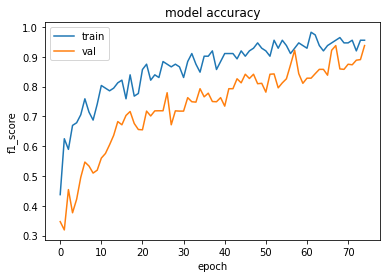

In [59]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_f1_score'])
plt.title('model accuracy')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

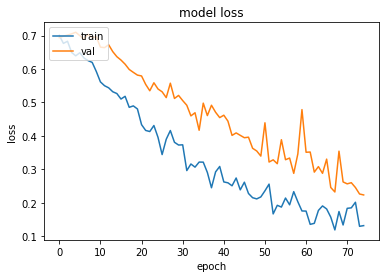

In [60]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Not bad for a model that was built from scratch, acheiving an F1 accurary of 93% on a custom model. Overall the trend in accuracy and loss is improving with epoch. We could try to improve this model using transfer learning